In [361]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
from matplotlib.lines import Line2D
import scipy as sp
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
SAVEFIG = True

### Data Preparation and Preprocessing

In [362]:
# import dataframe with both real data and simulation data
with open("simu1_data/simu1_behav.pkl", 'rb') as inp:
    df = pickle.load(inp)
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350


In [363]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df, category_label_dummies], axis=1) # record the occurrence of every cat label
cl_rolling_sum = category_label_dummies_events.groupby('subject_ID').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df.merge(cl_rolling_sum, on=['subject_ID', 'position'])
df['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], axis = 1) # how many cat within 10 window
df['roll_cat_label_length'] = df['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
# option = "0-1-2+"
option = "0+1-2+"
# option = "0-1+"
if option == "0-1-2+":
    # option 0: 0, 1, >=2
    df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                    bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0', '1', '>=2']).astype('str')
elif option == "0+1-2+":
    # option 1: 0-1, >=2
    df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                    bins=[0, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0-1', '>=2']).astype('str')
elif option == "0-1+":
    # option 2: 0, >=1
    df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                    bins=[0, 1, np.inf], right=False, include_lowest = True,
                                    labels=['0', '>=1']).astype('str')
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0-1
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0-1
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0-1
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,0-1
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0-1
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0-1


In [364]:
# add log and log lag bin
df['log_lag'] = np.log(df['lag'])
df['log_lag_bin'] = pd.cut(df['log_lag'], np.arange(df['log_lag'].max()+1), labels=False, right=False)
df

/Users/bei/anaconda3/envs/cmr/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0-1,-inf,NaN
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0-1,-inf,NaN
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0-1,-inf,NaN
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,0-1,-inf,NaN
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0-1,-inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2,3.610918,3.0
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0-1,4.744932,4.0
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2,3.178054,3.0
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0-1,3.713572,3.0


In [365]:
# construct local FAR
for i in range(1, len(df)):
    if df.loc[i, 'old'] == False and df.loc[i-1, 'old'] == True:
        df.loc[i, 'log_lag_bin'] = df.loc[i-1, 'log_lag_bin']
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0-1,-inf,NaN
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0-1,-inf,NaN
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0-1,-inf,NaN
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,0-1,-inf,NaN
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0-1,-inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2,3.610918,3.0
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0-1,4.744932,4.0
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2,3.178054,3.0
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0-1,3.713572,3.0


In [366]:
# # clean out NA resp
# df = df.loc[pd.notna(df.yes)].reset_index(drop=True)
# df = df.astype({'yes': 'int32'})
# df

In [367]:
# # focus on old items
# df_old = df.loc[df.lag > 0].reset_index(drop=True)

# # add log and log lag bin
# df_old['log_lag'] = np.log(df_old['lag'])
# df_old['log_lag_bin'] = pd.cut(df_old['log_lag'], np.arange(df_old['log_lag'].max()+1), labels=False, right=False)

# # add lag bin
# # df_old = df_old.assign(lag_bin = np.ceil(np.log2(df_old['lag'])))
# df_old

### Hit Recency with Rolling Category Length Level

In [368]:
# df_old.groupby("log_lag_bin").yes.count()

In [369]:
# df_old.groupby("roll_cat_len_level").yes.count()

In [370]:
df.groupby(["old", "log_lag_bin", "roll_cat_len_level"]).yes.count()

old    log_lag_bin  roll_cat_len_level
False  0.0          0-1                    2100
                    >=2                    1812
       1.0          0-1                    3943
                    >=2                    2421
       2.0          0-1                    7249
                    >=2                    3736
       3.0          0-1                    9491
                    >=2                    4522
       4.0          0-1                    6579
                    >=2                    3367
       5.0          0-1                    1293
                    >=2                     590
       6.0          0-1                       8
                    >=2                      22
True   0.0          0-1                    2674
                    >=2                    4078
       1.0          0-1                    3611
                    >=2                    8415
       2.0          0-1                   15794
                    >=2                    5986
 

#### Log

In [371]:
# mean of log bin for every subject
df['log_lag_bin'] = df.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
df_5 = df.query('log_lag_bin <= 5')

# count and add 0.5 / 1 to numerator / denominator, to avoid 0 and 1
df_rollcat_laggp = df_5.groupby(['subject_ID','old','roll_cat_len_level','log_lag_bin'])['yes'].agg(['mean', 'sum', 'count']).reset_index()
df_rollcat_laggp.rename(columns={'mean': 'yes_rate'}, inplace=True)
df_rollcat_laggp['yes_rate_adj'] = (df_rollcat_laggp['sum'] + 0.5) / (df_rollcat_laggp['count'] + 1)
# df_rollcat_laggp = df_5.groupby(['subject_ID','old','roll_cat_len_level','log_lag_bin'])['yes'].mean().to_frame(name='yes_rate').reset_index()

# log lag for display
df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
df_rollcat_laggp

,subject_ID,old,roll_cat_len_level,log_lag_bin,yes_rate,sum,count,yes_rate_adj,log_lag_disp
0,0,False,0-1,0.0,0.264706,9,34,0.271429,1.0
1,0,False,0-1,2.0,0.3,6,20,0.309524,8.0
2,0,False,0-1,3.0,0.181818,4,22,0.195652,21.0
3,0,False,0-1,4.0,0.25,3,12,0.269231,55.0
4,0,False,>=2,0.0,0.28125,9,32,0.287879,1.0
...,...,...,...,...,...,...,...,...,...
6445,656,True,>=2,0.0,0.894737,17,19,0.875,1.0
6446,656,True,>=2,2.0,1.0,5,5,0.916667,8.0
6447,656,True,>=2,3.0,0.777778,7,9,0.75,21.0
6448,656,True,>=2,4.0,0.6,3,5,0.583333,55.0


In [372]:
# pivot for hr and far
df_rollcat_laggp['old'] = df_rollcat_laggp['old'].astype('str')
df_dprime = pd.pivot_table(df_rollcat_laggp, values=['yes_rate', 'yes_rate_adj'], index=['subject_ID', 'roll_cat_len_level', 'log_lag_disp'], columns='old').reset_index()
df_dprime.columns = [' '.join(col).strip() for col in df_dprime.columns.values]
df_dprime = df_dprime.rename(columns={'yes_rate False': 'far', 'yes_rate True': 'hr', 'yes_rate_adj False': 'far_adj', 'yes_rate_adj True': 'hr_adj'})

# df_dprime = au.loftus_masson(df_dprime, 'subject_ID', ['roll_cat_len_level', 'log_lag_disp'], 'hr') - previous wrong!!
df_dprime

,subject_ID,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj
0,0,0-1,1.0,0.264706,0.971429,0.271429,0.958333
1,0,0-1,8.0,0.3,0.953488,0.309524,0.943182
2,0,0-1,21.0,0.181818,0.983051,0.195652,0.975
3,0,0-1,55.0,0.25,0.931034,0.269231,0.916667
4,0,>=2,1.0,0.28125,1.0,0.287879,0.994253
...,...,...,...,...,...,...,...
3337,656,>=2,1.0,0.1,0.894737,0.136364,0.875
3338,656,>=2,8.0,0.125,1.0,0.166667,0.916667
3339,656,>=2,21.0,0.266667,0.777778,0.28125,0.75
3340,656,>=2,55.0,0.157895,0.6,0.175,0.583333


In [373]:
# calculate dprime
df_dprime['z_hr'] = sp.stats.norm.ppf(df_dprime['hr_adj'])
df_dprime['z_far'] = sp.stats.norm.ppf(df_dprime['far_adj'])
df_dprime['dprime'] = df_dprime['z_hr'] - df_dprime['z_far']
df_dprime

,subject_ID,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj,z_hr,z_far,dprime
0,0,0-1,1.0,0.264706,0.971429,0.271429,0.958333,1.731664,-0.608498,2.340163
1,0,0-1,8.0,0.3,0.953488,0.309524,0.943182,1.582058,-0.497201,2.079258
2,0,0-1,21.0,0.181818,0.983051,0.195652,0.975,1.959964,-0.857254,2.817218
3,0,0-1,55.0,0.25,0.931034,0.269231,0.916667,1.382994,-0.615141,1.998135
4,0,>=2,1.0,0.28125,1.0,0.287879,0.994253,2.527302,-0.559592,3.086895
...,...,...,...,...,...,...,...,...,...,...
3337,656,>=2,1.0,0.1,0.894737,0.136364,0.875,1.150349,-1.096804,2.247153
3338,656,>=2,8.0,0.125,1.0,0.166667,0.916667,1.382994,-0.967422,2.350416
3339,656,>=2,21.0,0.266667,0.777778,0.28125,0.75,0.674490,-0.579132,1.253622
3340,656,>=2,55.0,0.157895,0.6,0.175,0.583333,0.210428,-0.934589,1.145018


In [374]:
# df_rollcat_laggp_old = au.loftus_masson(df_rollcat_laggp_old, 'subject_ID', ['roll_cat_len_level', 'log_lag_bin'], 'hr')
# df_rollcat_laggp_old

In [375]:
# def loglag_rollcat(df, resp_col):

#     df_rollcat_laggp = df.groupby(['subject_ID','roll_cat_len_level','log_lag_bin'])[resp_col].mean()
#     df_rollcat_laggp = df_rollcat_laggp.to_frame(name='hr').reset_index()
#     df_rollcat_laggp = au.loftus_masson(df_rollcat_laggp, 'subject_ID', ['roll_cat_len_level', 'log_lag_bin'], 'hr')
    
#     # df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_len_level,['0','>=2'])]
#     # df_rollcat_laggp.roll_cat_len_level = df_rollcat_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
    
#     return df_rollcat_laggp

In [376]:
# df_old['log_lag_bin'] = df_old.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
# df_rollcat_laggp = loglag_rollcat(df_old.query('log_lag_bin <= 5'),'yes')
# df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
# df_rollcat_laggp
# # 1~7 -> 1(0,1), 8~20 -> 8(2), 21~54 -> 21(3), 55~148 -> 55(4), 149~403 -> 149(5)

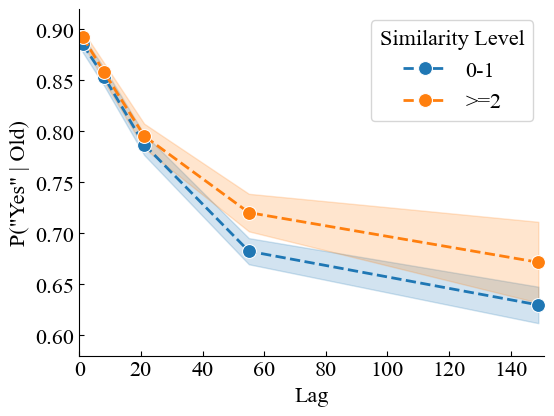

In [377]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='hr', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('P("Yes" | Old)')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_hr_{option}.pdf')

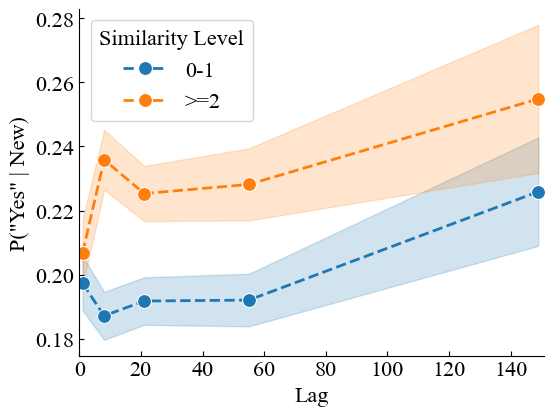

In [378]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='far', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('P("Yes" | New)')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
# plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_far_{option}.pdf')

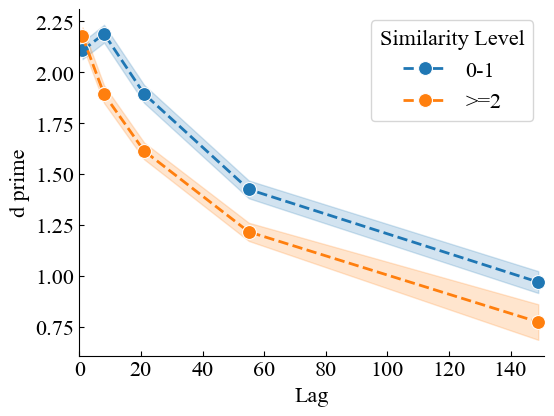

In [379]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='dprime', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('d prime')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
# plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_dprime_{option}.pdf')